In [3]:
import polars as pl 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # For formatting dates on the x-axis
import matplotlib.ticker as mticker 
import seaborn as sns
import datetime
pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(20)
pl.Config.set_float_precision(3)

polars.config.Config

In [4]:
def plot_polars_timeseries(
    df: pl.DataFrame,
    time_col: str,
    value_col: str,
    title: str = "Time Series Plot",
    xlabel: str | None = None, # Default to time_col name
    ylabel: str | None = None, # Default to value_col name
    style: str = "darkgrid", # Seaborn style
    line_color: str = "maroon",
    line_width: float = 1.5,
    marker: str | None = None, # e.g., 'o' for circles
    figsize: tuple[float, float] = (12, 6),
    date_format_str: str = "%Y-%m-%d", # For formatting x-axis ticks
    save_path: str | None = None
) -> None:
    """
    Creates and displays a styled time series plot from a Polars DataFrame.

    Args:
        df: The input Polars DataFrame.
        time_col: The name of the column containing datetime or date objects for the x-axis.
        value_col: The name of the column containing the numeric values for the y-axis.
        title: The title of the plot.
        xlabel: The label for the x-axis. Defaults to the name of time_col.
        ylabel: The label for the y-axis. Defaults to the name of value_col.
        style: The Seaborn style to apply (e.g., "darkgrid", "whitegrid", "ticks").
        line_color: Color of the plot line.
        line_width: Width of the plot line.
        marker: Marker style for data points (e.g., 'o', '.', 's'). None for no marker.
        figsize: Tuple specifying the figure size (width, height) in inches.
        date_format_str: The format string for date ticks on the x-axis.
        save_path: Optional path to save the figure. If None, the plot is only shown.
    """
    if xlabel is None:
        xlabel = time_col.replace("_", " ").title()
    if ylabel is None:
        ylabel = value_col.replace("_", " ").title()

    # Apply Seaborn style
    try:
        sns.set_theme(style=style)
    except Exception as e:
        print(f"Warning: Could not set seaborn style '{style}'. Using default. Error: {e}")
        # Fallback or just proceed with matplotlib defaults

    # Ensure the DataFrame is sorted by the time column for correct plotting
    # Also, ensure the time column is in a pl.Datetime or pl.Date format if it's not already
    # For this example, we assume it's already in a suitable format or can be directly plotted.
    # If your time_col is string, you would convert it first:
    # df = df.with_columns(pl.col(time_col).str.to_datetime(format="%Y-%m-%d %H:%M:%S"))
    df_sorted = df.sort(time_col)

    # Extract data for plotting
    # Matplotlib can often plot Polars Series directly, especially if they are numeric.
    # If issues arise, convert to NumPy: .to_numpy()
    time_data = df_sorted[time_col]
    value_data = df_sorted[value_col]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(
        time_data,
        value_data,
        color=line_color,
        linewidth=line_width,
        marker=marker if marker else '' # Ensure marker is empty string if None for plt.plot
    )

    # Set title and labels
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel(xlabel, fontsize=12, labelpad=15)
    plt.ylabel(ylabel, fontsize=12, labelpad=15)

    # Improve x-axis date formatting
    # This formats the dates displayed on the x-axis.
    # It works best if time_data consists of Python datetime objects or similar.
    # Polars Datetime/Date columns are usually handled well by Matplotlib.
    ax = plt.gca() # Get current axes
    # Improve x-axis date formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format_str))
    plt.gcf().autofmt_xdate()

    # Format y-axis to avoid scientific notation
    y_formatter = mticker.ScalarFormatter(useOffset=False)
    y_formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(y_formatter)

    # Add a grid for better readability (Seaborn styles often include grids)
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add some padding to the layout
    plt.tight_layout(pad=1.5)

    # Save the plot if a path is provided
    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")

    # Show the plot
    plt.show()

def plot_polars_histogram_kde(
    df: pl.DataFrame,
    value_col: str,
    title: str = "Histogram with KDE",
    xlabel: str | None = None, # Default to value_col name
    ylabel: str = "Density",
    bins: int | str = "auto", # Number of bins or strategy (e.g., "auto", "fd", "sqrt")
    style: str = "darkgrid",
    hist_color: str = "cornflowerblue",
    kde_color: str = "red",
    kde_linewidth: float = 2,
    figsize: tuple[float, float] = (10, 6),
    save_path: str | None = None
) -> None:
    """
    Creates and displays a styled histogram with a Kernel Density Estimate (KDE)
    overlay for a column in a Polars DataFrame.

    Args:
        df: The input Polars DataFrame.
        value_col: The name of the column containing numeric values to plot.
        title: The title of the plot.
        xlabel: The label for the x-axis. Defaults to the name of value_col.
        ylabel: The label for the y-axis.
        bins: Number of bins for the histogram or a binning strategy string.
        style: The Seaborn style to apply.
        hist_color: Color of the histogram bars.
        kde_color: Color of the KDE line.
        kde_linewidth: Width of the KDE line.
        figsize: Tuple specifying the figure size (width, height) in inches.
        save_path: Optional path to save the figure. If None, the plot is only shown.
    """
    df = df.filter(pl.col(value_col).abs().lt(100000))
    if xlabel is None:
        xlabel = value_col.replace("_", " ").title()

    # Apply Seaborn style
    try:
        sns.set_theme(style=style)
    except Exception as e:
        print(f"Warning: Could not set seaborn style '{style}'. Using default. Error: {e}")

    # Extract data for plotting.
    # Seaborn's histplot can often take a Polars Series directly.
    # If issues, convert to NumPy array or Pandas Series: df[value_col].to_numpy()
    data_to_plot = df[value_col]

    # Create the plot
    plt.figure(figsize=figsize)

    # Plot histogram with KDE using Seaborn
    # `stat="density"` normalizes histogram to form a probability density.
    sns.histplot(
        data_to_plot,
        bins=bins,
        kde=True,
        stat="density", # Use "density" for KDE overlay to make sense, or "count"/"frequency"
        color=hist_color,
        line_kws={'linewidth': kde_linewidth, 'color': kde_color}, # For KDE line
        edgecolor='black', # Optional: add edges to bars
        alpha=0.7 # Opacity of histogram bars
    )

    # Set title and labels
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel(xlabel, fontsize=12, labelpad=15)
    plt.ylabel(ylabel, fontsize=12, labelpad=15)

    # Get current axes
    ax = plt.gca()

    # Format x-axis to avoid scientific notation
    x_formatter = mticker.ScalarFormatter(useOffset=False)
    x_formatter.set_scientific(False)
    ax.xaxis.set_major_formatter(x_formatter)

    plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout(pad=1.5)

    if save_path:
        try:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Plot saved to {save_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")
    plt.show()

def calculate_pnl_statistics(
    df: pl.DataFrame,
    pnl_col_name: str,
    annualization_factor: int = 252,
    risk_free_rate_daily: float = 0.0,
    portfolio_size_for_drawdown: float = 1_000_000.0
) -> pl.DataFrame:
    """
    Calculates various performance statistics from a daily PnL column (assumed to be fractional returns).
    Returns a Polars DataFrame with statistics as numeric types (float or null).
    Drawdowns are scaled based on the `portfolio_size_for_drawdown`.

    Args:
        df: Polars DataFrame containing the PnL data.
        pnl_col_name: Name of the column with daily PnL values (assumed to be fractional returns, e.g., 0.01 for 1%).
        annualization_factor: Factor for annualizing Sharpe Ratio (e.g., 252 for daily PnL).
        risk_free_rate_daily: Daily risk-free rate for Sharpe Ratio calculation.
        portfolio_size_for_drawdown: The portfolio size to scale drawdown calculations against.

    Returns:
        A Polars DataFrame containing the calculated statistics as numeric values.
    """
    pnl_series = df[pnl_col_name].drop_nulls()

    stat_names_list = [
        "Mean Daily PnL ", "Std Dev Daily PnL", "Annualized Sharpe Ratio", "Win Rate",
        "Max Daily Win ", "Max Daily Loss ",
        "Worst 5-Day Cumulative PnL %",
        "Worst 20-Day Cumulative PnL %",
        "Skewness", "Kurtosis",
        "Average Win Amount", "Average Loss Amount",
        "CAGR %",
        "Annualized CAGR %",
    ]

    if pnl_series.len() == 0:
        print(f"Warning: PnL column '{pnl_col_name}' is empty or all nulls. Returning nulls for stats.")
        return pl.DataFrame({
            "Statistic": stat_names_list,
            "Value": [None] * len(stat_names_list) # Use None for missing numeric data
        }, schema={"Statistic": pl.String, "Value": pl.Float64})


    # Basic PnL Stats
    mean_pnl = pnl_series.mean()
    std_pnl = pnl_series.std()

    # Sharpe Ratio (Annualized)
    if std_pnl is not None and std_pnl != 0:
        sharpe_ratio = ((mean_pnl - risk_free_rate_daily) / std_pnl) * (annualization_factor ** 0.5)
    elif mean_pnl is not None and mean_pnl == 0 and (std_pnl is None or std_pnl == 0) :
        sharpe_ratio = 0.0
    else:
        sharpe_ratio = None # Use None for potentially undefined numeric result

    # Win Rate
    wins = pnl_series.filter(pnl_series > 0).len()
    total_days = pnl_series.len()
    win_rate = float(wins) / total_days if total_days > 0 else 0.0 # Ensure float division

    # Max Win / Max Loss (Single Day)
    max_daily_win = pnl_series.max()
    max_daily_loss = pnl_series.min()

    # Helper for N-Day Drawdown
    def calculate_worst_n_day_pnl_scaled(series: pl.Series, n: int, scaling_factor: float) -> float | None:
        if series.len() < n:
            return None # Return None for insufficient data
        rolling_sum_pnl = series.rolling_sum(window_size=n, min_periods=n)
        min_rolling_sum_fractional = rolling_sum_pnl.min()
        if min_rolling_sum_fractional is None:
            return None
        return min_rolling_sum_fractional / scaling_factor

    worst_5_day_pnl_scaled = calculate_worst_n_day_pnl_scaled(pnl_series, 5, portfolio_size_for_drawdown)
    worst_20_day_pnl_scaled = calculate_worst_n_day_pnl_scaled(pnl_series, 20, portfolio_size_for_drawdown)

    # Skewness and Kurtosis
    skewness = pnl_series.skew() if pnl_series.len() > 2 else None
    kurt = pnl_series.kurtosis() if pnl_series.len() > 3 else None # Polars calculates excess kurtosis

    # Average Win / Loss Amounts
    winners_series = pnl_series.filter(pnl_series > 0)
    losers_series = pnl_series.filter(pnl_series < 0)

    avg_win_amount = winners_series.mean() if winners_series.len() > 0 else 0.0
    avg_loss_amount = losers_series.mean() if losers_series.len() > 0 else 0.0

    # CAGR (Compound Annual Growth Rate)
    cagr = ((((pnl_series.cast(pl.Float64).cum_sum() + 1e6)/1e6).last()-1) * 100)
    num_days_for_cagr = pnl_series.len()
    annualized_cagr = ((1+cagr/100)**(252/num_days_for_cagr) - 1) * 100
    
    # Prepare list of numeric values for the DataFrame
    stat_values_list = [
        mean_pnl,
        std_pnl,
        sharpe_ratio,
        win_rate * 100, # Already a float
        max_daily_win,
        max_daily_loss,
        worst_5_day_pnl_scaled * 100,
        worst_20_day_pnl_scaled * 100,
        skewness,
        kurt,
        avg_win_amount,
        avg_loss_amount,
        cagr,
        annualized_cagr
    ]
    
    # Ensure all values are float or None for consistent DataFrame column type
    processed_stat_values_list = [float(v) if isinstance(v, (int, float)) and not (isinstance(v, float) and pl.Series([v], dtype=pl.Float64).is_nan()[0]) else (None if v is None or (isinstance(v, float) and pl.Series([v], dtype=pl.Float64).is_nan()[0]) else v) for v in stat_values_list]


    return pl.DataFrame({
        "Statistic": stat_names_list,
        "Value": processed_stat_values_list
    }, schema={"Statistic": pl.String, "Value": pl.Float64})

def plot_daily_pnl_bar(
    df: pl.DataFrame,
    date_col: str,
    pnl_col: str,
    title: str = "Daily PnL", # Base title for daily, will be adjusted for weekly
    xlabel: str | None = None,
    ylabel: str | None = None,
    style: str = "seaborn-v0_8-darkgrid",
    positive_color: str = "mediumseagreen",
    negative_color: str = "lightcoral",
    figsize: tuple[float, float] = (15, 7),
    date_format_str: str = "%Y-%m-%d", # Used for x-axis tick formatting
    save_path: str | None = None,
    aggregation_period: str = "daily" # "daily" or "weekly"
) -> None:
    """
    Creates and displays bar plots of PnL.
    If aggregation_period is "daily", plots are for distinct 6-month periods.
    If aggregation_period is "weekly", plots aggregated weekly PnL for the entire duration.

    Args:
        df: The input Polars DataFrame.
        date_col: The name of the column containing datetime or date objects for the x-axis.
        pnl_col: The name of the column containing the daily PnL values.
        title: The base title for the plots. Period information will be appended.
        xlabel: The label for the x-axis. Defaults to the name of date_col.
        ylabel: The label for the y-axis. Defaults to the name of pnl_col.
        style: The Seaborn style to apply.
        positive_color: Color for positive PnL bars.
        negative_color: Color for negative PnL bars.
        figsize: Tuple specifying the figure size (width, height) in inches for each plot.
        date_format_str: The format string for date ticks on the x-axis.
        save_path: Optional base path to save the figures. Period info will be appended for daily.
                   If None, plots are only shown.
        aggregation_period: "daily" or "weekly". Determines how PnL is aggregated and plotted.
    """
    # Drop rows where essential columns (date or pnl) are null
    df_cleaned = df.drop_nulls(subset=[date_col, pnl_col])
    if df_cleaned.is_empty():
        print(f"DataFrame is empty after dropping nulls in '{date_col}' or '{pnl_col}'. Cannot plot PnL.")
        return
    if date_col not in df_cleaned.columns: # Should not happen if drop_nulls worked on existing cols
        print(f"Date column '{date_col}' not found in DataFrame.")
        return
    if pnl_col not in df_cleaned.columns:
        print(f"PnL column '{pnl_col}' not found in DataFrame.")
        return

    if xlabel is None:
        xlabel = date_col.replace("_", " ").title()
    if ylabel is None:
        ylabel = pnl_col.replace("_", " ").title()

    try:
        sns.set_theme(style=style)
    except Exception as e:
        print(f"Warning: Could not set seaborn style '{style}'. Using default. Error: {e}")

    # Ensure date_col is a Date or Datetime type for dt operations
    if not isinstance(df_cleaned[date_col].dtype, (pl.Date, pl.Datetime)):
        print(f"Warning: Date column '{date_col}' is not a Date or Datetime type. Attempting conversion to Date.")
        try:
            df_cleaned = df_cleaned.with_columns(pl.col(date_col).cast(pl.Date))
        except Exception as cast_err:
            print(f"Error converting date column '{date_col}': {cast_err}. Plotting may fail.")
            return
    
    # --- Plotting Function (shared logic for a single plot) ---
    def _plot_single_pnl_chart(data_df, x_data_col, y_data_col, plot_title, current_save_path):
        dates_to_plot = data_df[x_data_col].to_list()
        pnl_values_to_plot = data_df[y_data_col].to_list()
        
        if not dates_to_plot: # Skip if no data for this period
            print(f"No data to plot for period related to title: {plot_title}")
            return

        colors = [positive_color if pnl >= 0 else negative_color for pnl in pnl_values_to_plot]

        plt.figure(figsize=figsize)
        # Adjust bar width based on number of data points for better visuals
        num_bars = len(dates_to_plot)
        bar_width = 0.8 if aggregation_period == "daily" else 5.0 # Wider for weekly if fewer bars
        if num_bars < 30 and aggregation_period == "weekly": # Heuristic for weekly plots
            bar_width = max(1.0, 7 - num_bars * 0.1)


        plt.bar(dates_to_plot, pnl_values_to_plot, color=colors, width=bar_width)

        plt.title(plot_title, fontsize=16, pad=20)
        plt.xlabel(xlabel, fontsize=12, labelpad=15)
        plt.ylabel(ylabel, fontsize=12, labelpad=15)

        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format_str))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        y_formatter = mticker.ScalarFormatter(useOffset=False)
        y_formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(y_formatter)
        
        ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.tight_layout(pad=1.5)

        if current_save_path:
            try:
                plt.savefig(current_save_path, dpi=300, bbox_inches='tight')
                print(f"Plot saved to {current_save_path}")
            except Exception as e:
                print(f"Error saving plot to {current_save_path}: {e}")
        
        plt.show()

    # --- Main logic for daily vs weekly ---
    if aggregation_period == "weekly":
        df_weekly = (
            df_cleaned
            .group_by(pl.col(date_col).dt.truncate("1w").alias("week_start_date"))
            .agg(pl.col(pnl_col).sum().alias(pnl_col)) # Sum PnL for the week
            .sort("week_start_date")
        )
        
        if df_weekly.is_empty():
            print("No data after weekly aggregation.")
            return
            
        weekly_title = title.replace("Daily", "Weekly") if "Daily" in title else f"Weekly {title}"
        _plot_single_pnl_chart(df_weekly, "week_start_date", pnl_col, weekly_title, save_path)

    elif aggregation_period == "daily":
        df_with_period = df_cleaned.sort(date_col).with_columns([
            pl.col(date_col).dt.year().alias("plot_year"),
            (((pl.col(date_col).dt.month() - 1) // 6) + 1).alias("plot_semester") # 1 for H1, 2 for H2
        ])

        period_groups = df_with_period.select(["plot_year", "plot_semester"]).unique().sort(["plot_year", "plot_semester"])

        if period_groups.is_empty():
            print("No data periods found to plot for daily aggregation.")
            return

        for row in period_groups.iter_rows(named=True):
            year, semester = row["plot_year"], row["plot_semester"]
            
            df_period_daily = df_with_period.filter(
                (pl.col("plot_year") == year) & (pl.col("plot_semester") == semester)
            )

            if df_period_daily.is_empty():
                continue

            period_min_date = df_period_daily[date_col].min()
            period_max_date = df_period_daily[date_col].max()
            
            daily_period_title = f"{title} ({year} H{semester}: {period_min_date.strftime('%b %Y')} - {period_max_date.strftime('%b %Y')})"
            
            current_daily_save_path = None
            if save_path:
                base, ext = os.path.splitext(save_path)
                current_daily_save_path = f"{base}_{year}H{semester}{ext}"
            
            _plot_single_pnl_chart(df_period_daily, date_col, pnl_col, daily_period_title, current_daily_save_path)
    else:
        print(f"Error: Unsupported aggregation_period '{aggregation_period}'. Choose 'daily' or 'weekly'.")

In [5]:
df = pl.read_csv("/htaa/llanteigne/1dte.csv")
df = df.with_columns(pl.col('date').str.to_date())

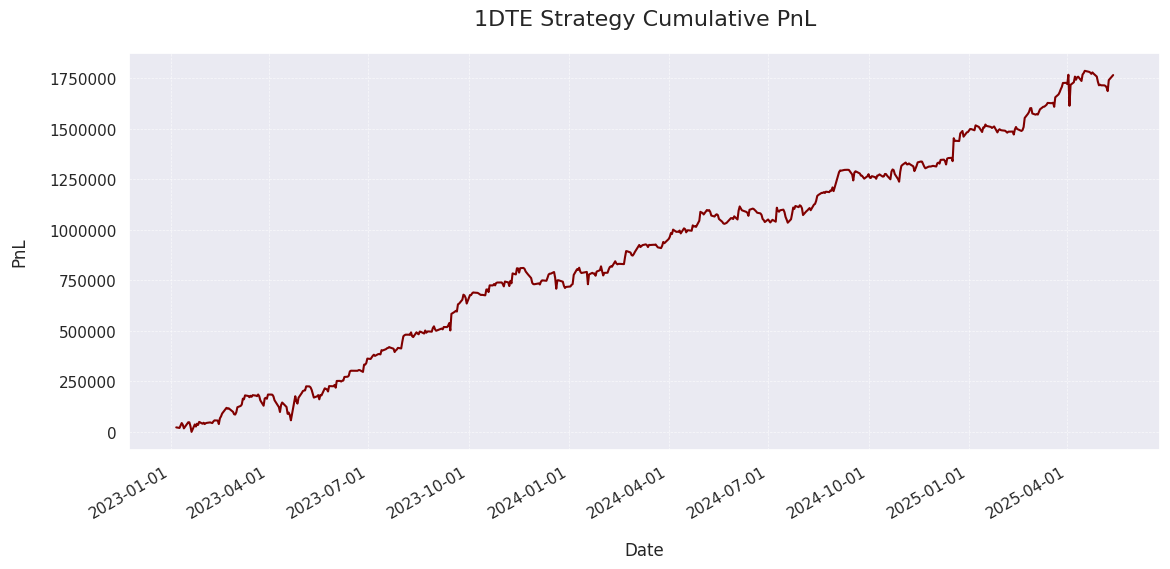

In [6]:
plot_polars_timeseries(df, time_col='date', value_col='ret_uprc_signal_pnl_cumsum', title='1DTE Strategy Cumulative PnL', ylabel='PnL')

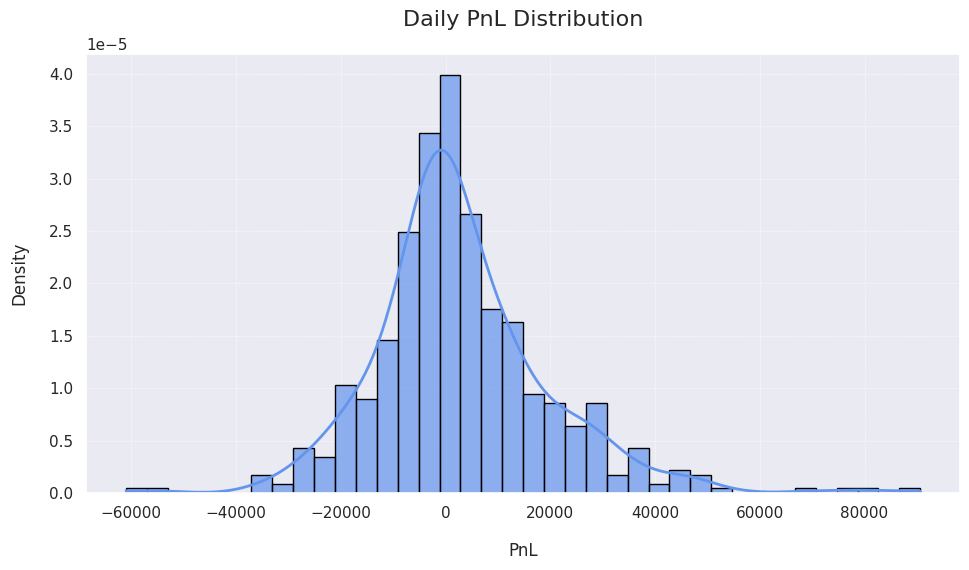

In [7]:
plot_polars_histogram_kde(df,'ret_uprc_signal_pnl', title="Daily PnL Distribution", xlabel="PnL")

In [8]:
calculate_pnl_statistics(df, 'ret_uprc_signal_pnl')

Statistic,Value
str,f64
"""Mean Daily PnL """,3008.881
"""Std Dev Daily PnL""",18894.969
"""Annualized Sharpe Ratio""",2.528
"""Win Rate""",52.300
"""Max Daily Win """,113748.015
"""Max Daily Loss """,-153567.371
"""Worst 5-Day Cumulative PnL %""",-9.340
"""Worst 20-Day Cumulative PnL %""",-11.949
"""Skewness""",0.223


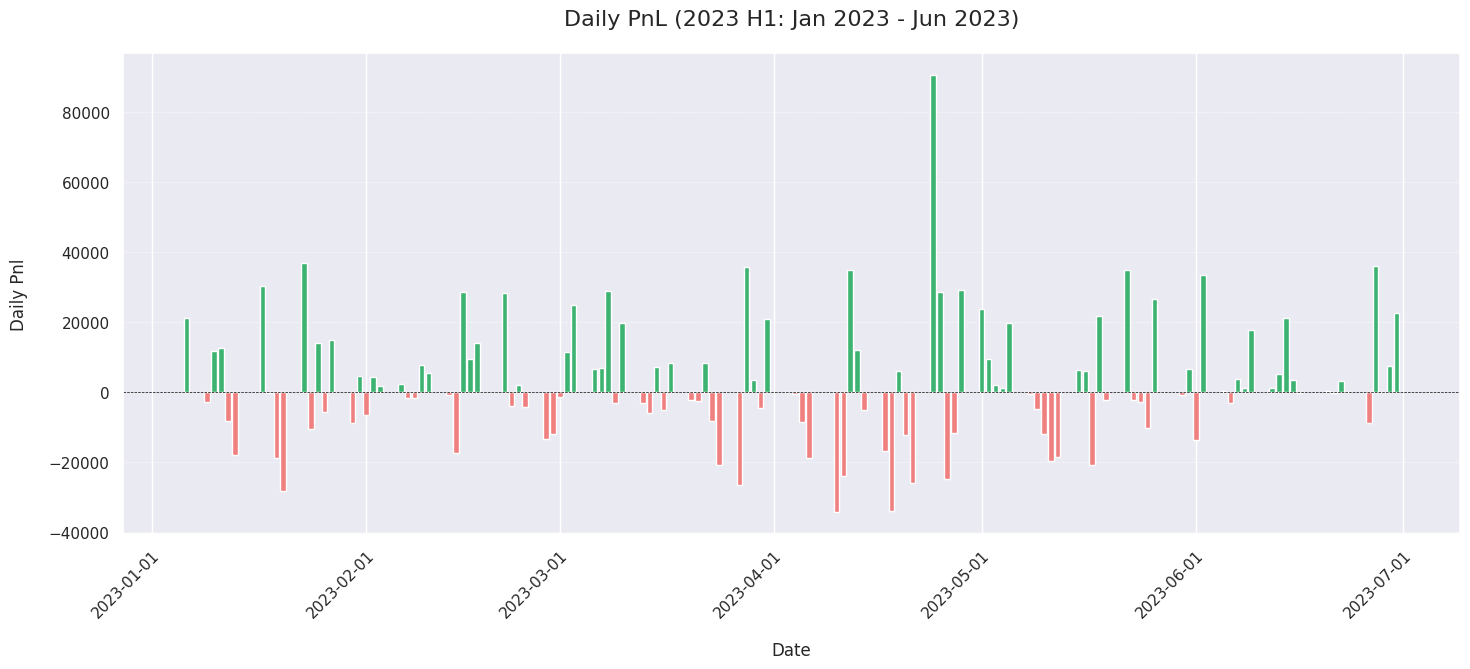

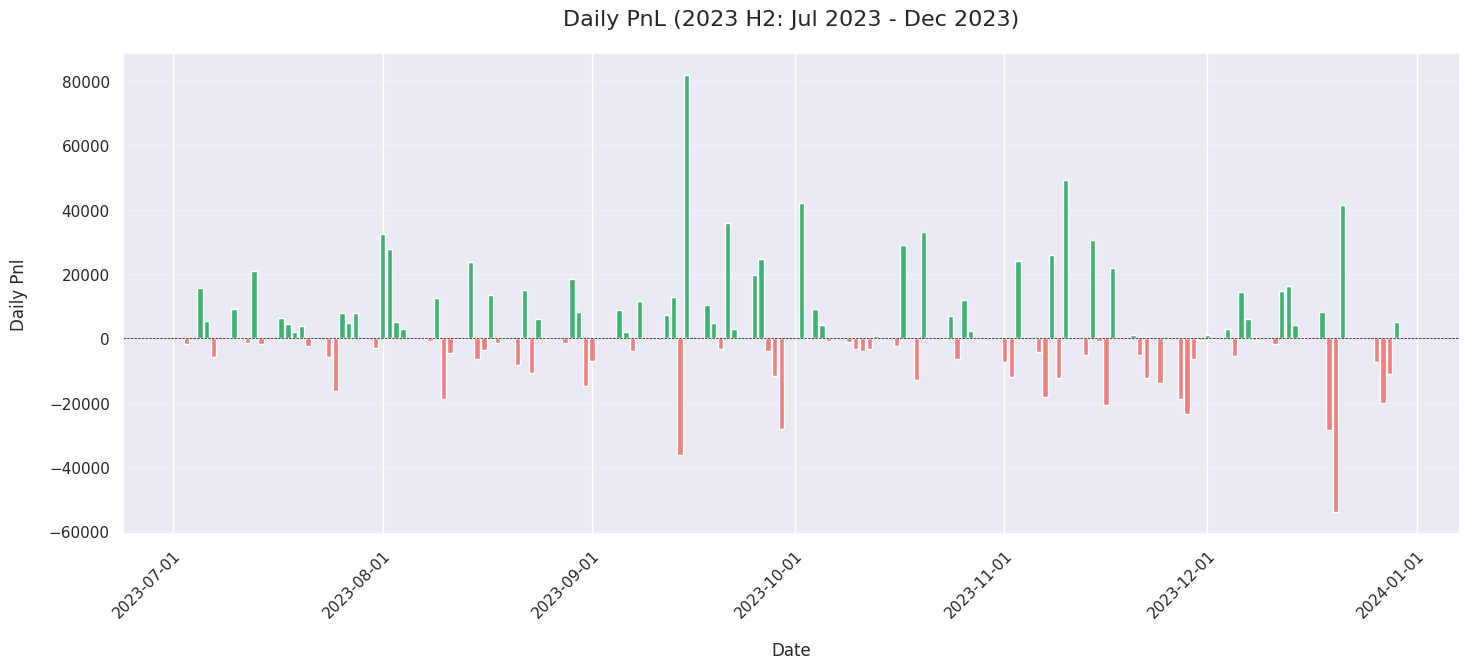

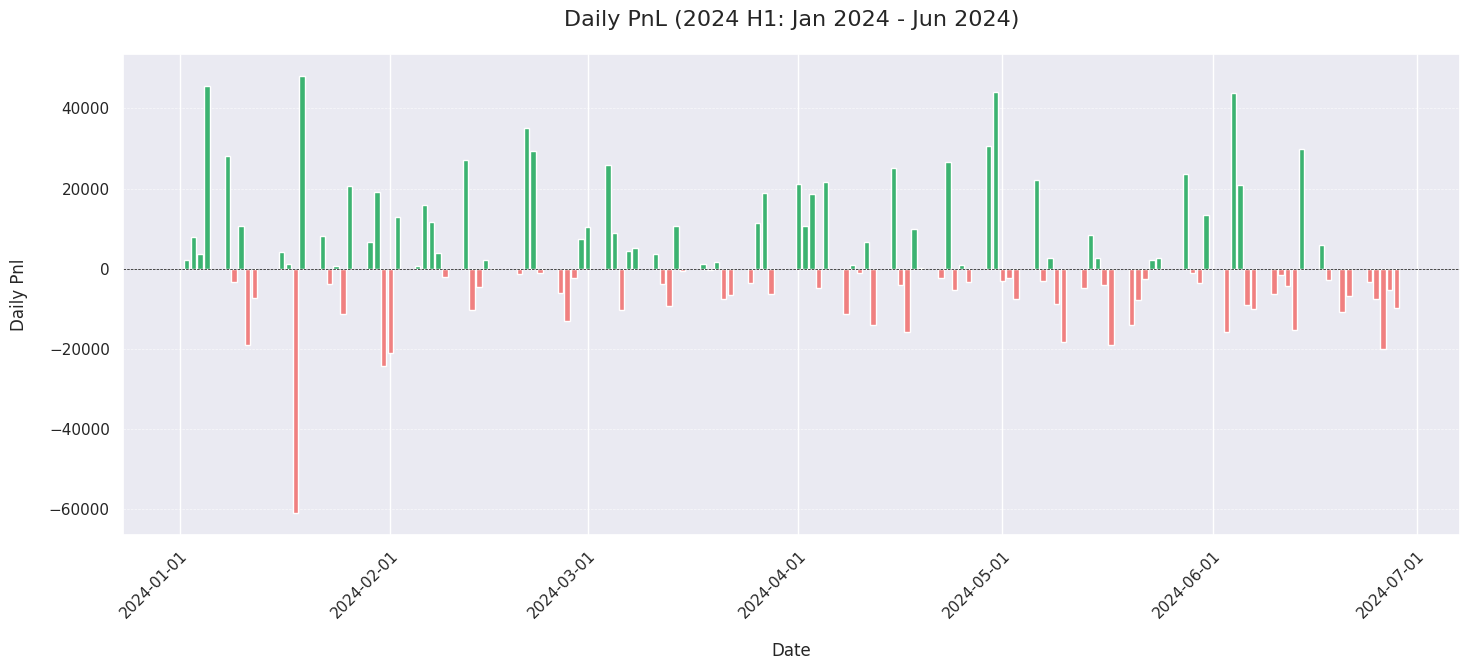

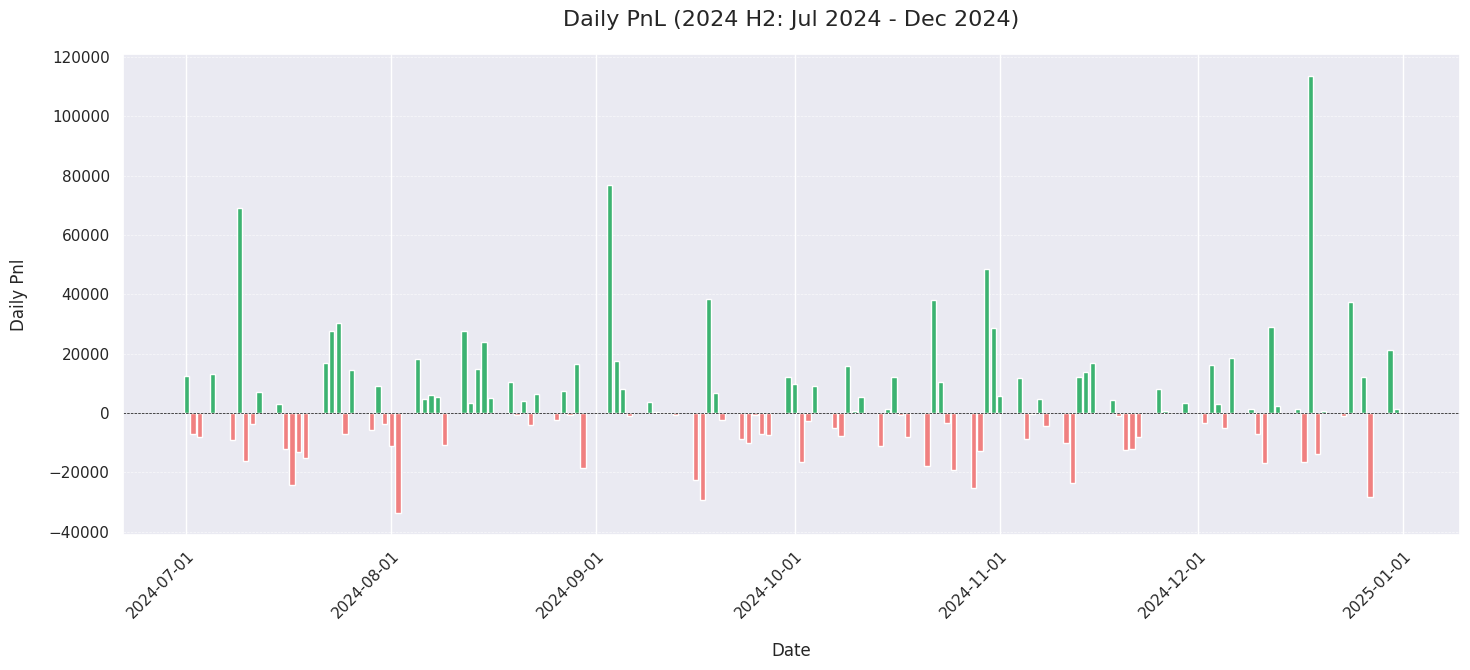

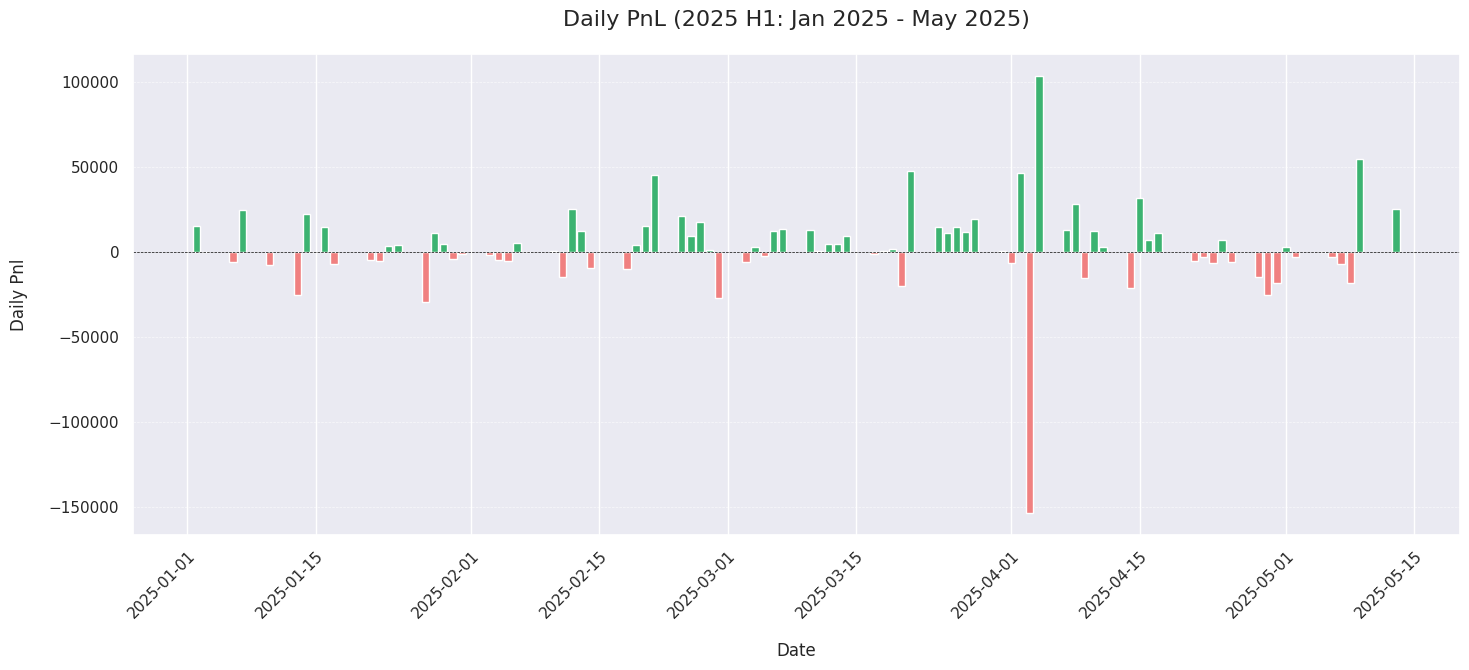

In [9]:
plot_daily_pnl_bar(df, 'date', 'ret_uprc_signal_pnl', ylabel="Daily Pnl")

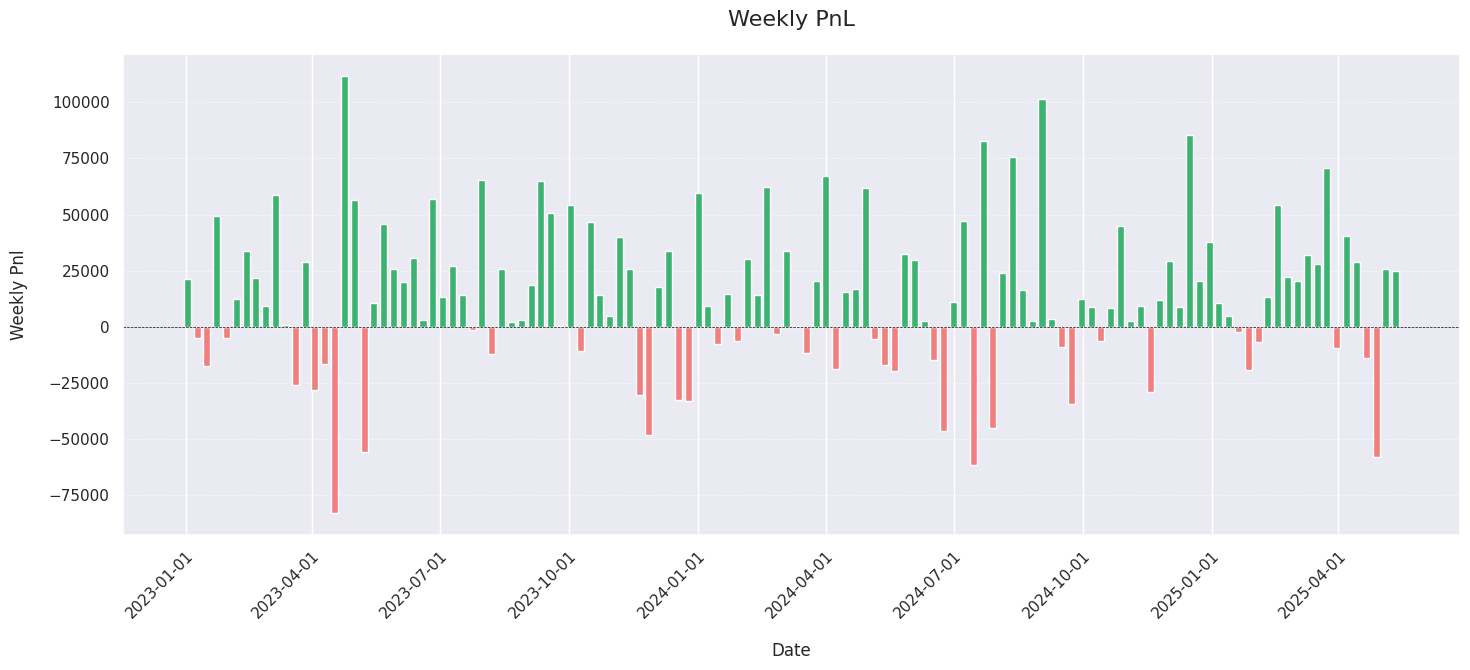

In [10]:
plot_daily_pnl_bar(df, 'date', 'ret_uprc_signal_pnl', ylabel="Weekly Pnl", aggregation_period='weekly')

In [12]:
df.drop_nulls()

,date,okey_xx,open_uprc,expiration,dist_to_strike,close_uprc,open_sprc_C,open_sprc_P,close_sprc_C,…,ret_sprc_lag_3_0.1,ret_uprc_lag_1_0.6,ret_uprc_lag_2_0.3,ret_uprc_lag_3_0.1,ret_sprc_signal,ret_uprc_signal,ret_sprc_signal_pnl,ret_uprc_signal_pnl,ret_sprc_signal_pnl_cumsum,ret_uprc_signal_pnl_cumsum
i64,date,f64,f64,str,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3,2023-01-06,3895.000,3895.080,"""2023-01-09""",0.080,3892.090,15.400,17.600,0.225,…,0.040,-0.360,-0.136,0.032,-0.440,-0.464,20606.145,21174.368,20606.145,21174.368
4,2023-01-09,3890.000,3892.090,"""2023-01-10""",2.090,3919.250,19.450,15.750,29.050,…,-0.045,0.547,-0.180,-0.045,0.344,0.322,-2989.721,-2718.621,17616.424,18455.747
5,2023-01-10,3920.000,3919.250,"""2023-01-11""",0.750,3969.610,13.950,14.600,46.750,…,-0.057,0.101,0.274,-0.060,0.328,0.315,10457.941,11614.088,28074.365,30069.835
6,2023-01-11,3970.000,3969.610,"""2023-01-12""",0.390,3983.170,38.450,40.300,13.500,…,0.094,-0.443,0.051,0.091,-0.237,-0.301,9825.160,12520.667,37899.524,42590.502
7,2023-01-12,3985.000,3983.170,"""2023-01-13""",1.830,3999.090,15.700,16.850,15.100,…,0.017,0.500,-0.221,0.017,0.323,0.295,-8641.484,-8372.579,29258.040,34217.922
8,2023-01-13,4000.000,3999.090,"""2023-01-17""",0.910,3990.970,14.900,14.600,0.025,…,-0.064,0.340,0.250,-0.074,0.506,0.516,-16997.049,-17914.280,12260.991,16303.642
9,2023-01-17,3990.000,3990.970,"""2023-01-18""",0.970,3928.860,16.300,15.800,0.025,…,0.083,0.416,0.170,0.083,0.647,0.670,31199.107,30295.221,43460.098,46598.863
10,2023-01-18,3930.000,3928.860,"""2023-01-19""",1.140,3898.850,14.000,16.250,0.025,…,0.054,-0.543,0.208,0.057,-0.324,-0.278,-40.143,-413.390,43419.954,46185.473
11,2023-01-19,3900.000,3898.850,"""2023-01-20""",1.150,3972.610,10.800,15.850,69.500,…,0.067,-0.018,-0.271,0.069,-0.224,-0.220,-18000.276,-18958.367,25419.678,27227.106
